# Regression  with NEAT

In this laboratory session, we will use **NEAT** to solve a regression problem. We will use the [Energy Efficiency Dataset](https://www.kaggle.com/datasets/elikplim/eergy-efficiency-dataset), which contains 8 attributes, denoted by **X1**, ..., **X8**, and 2 targets, denoted by y1 and y2. Specifically, we have:

- **X1** Relative Compactness
- **X2** Surface Area
- **X3** Wall Area
- **X4** Roof Area
- **X5** Overall Height
- **X6** Orientation
- **X7** Glazing Area
- **X8** Glazing Area Distribution
- **y1** Heating Load
- **y2** Cooling Load

Let us import some useful modules.

In [128]:
import neat
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import numpy as np
from sklearn.model_selection import train_test_split

random.seed(0)

We can load the data from the ```data``` directory.

In [129]:
data_path = "../data/ENB2012_data.xlsx"

df = pd.read_excel(data_path)
df.head(10)

,X1,X2,X3,X4,X5,X6,X7,X8,Y1,Y2
0,0.98,514.5,294.0,110.25,7.0,2,0.0,0,15.55,21.33
1,0.98,514.5,294.0,110.25,7.0,3,0.0,0,15.55,21.33
2,0.98,514.5,294.0,110.25,7.0,4,0.0,0,15.55,21.33
3,0.98,514.5,294.0,110.25,7.0,5,0.0,0,15.55,21.33
4,0.90,563.5,318.5,122.50,7.0,2,0.0,0,20.84,28.28
5,0.90,563.5,318.5,122.50,7.0,3,0.0,0,21.46,25.38
6,0.90,563.5,318.5,122.50,7.0,4,0.0,0,20.71,25.16
7,0.90,563.5,318.5,122.50,7.0,5,0.0,0,19.68,29.60
8,0.86,588.0,294.0,147.00,7.0,2,0.0,0,19.50,27.30
9,0.86,588.0,294.0,147.00,7.0,3,0.0,0,19.95,21.97


Explore the dataset and perform some preprocessing, if necessary.

In [130]:
df.describe()

,X1,X2,X3,X4,X5,X6,X7,X8,Y1,Y2
count,768.000000,768.000000,768.000000,768.000000,768.00000,768.000000,768.000000,768.00000,768.000000,768.000000
mean,0.764167,671.708333,318.500000,176.604167,5.25000,3.500000,0.234375,2.81250,22.307195,24.587760
std,0.105777,88.086116,43.626481,45.165950,1.75114,1.118763,0.133221,1.55096,10.090204,9.513306
min,0.620000,514.500000,245.000000,110.250000,3.50000,2.000000,0.000000,0.00000,6.010000,10.900000
25%,0.682500,606.375000,294.000000,140.875000,3.50000,2.750000,0.100000,1.75000,12.992500,15.620000
50%,0.750000,673.750000,318.500000,183.750000,5.25000,3.500000,0.250000,3.00000,18.950000,22.080000
75%,0.830000,741.125000,343.000000,220.500000,7.00000,4.250000,0.400000,4.00000,31.667500,33.132500
max,0.980000,808.500000,416.500000,220.500000,7.00000,5.000000,0.400000,5.00000,43.100000,48.030000


In [131]:
X = (df.drop(columns=df[['Y1', 'Y2']], axis=0))
y = (df.iloc[:, -2:])
X = (X-X.mean())/X.std()
correlation_matrix = df.corr()

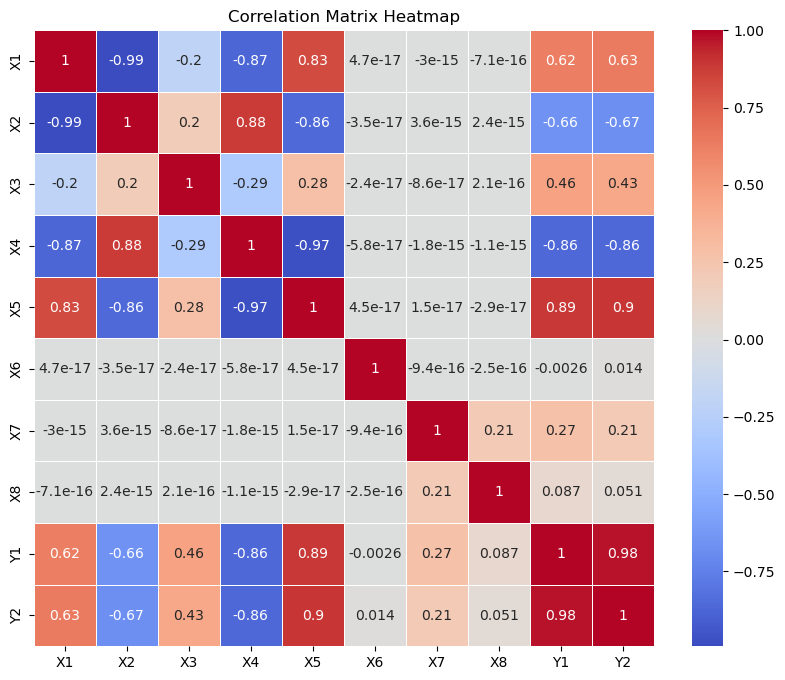

In [132]:
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Matrix Heatmap")
plt.show()

In [133]:
X = X.drop(columns=df[['X2', 'X4']], axis=0)
correlation_matrix = X.corr()

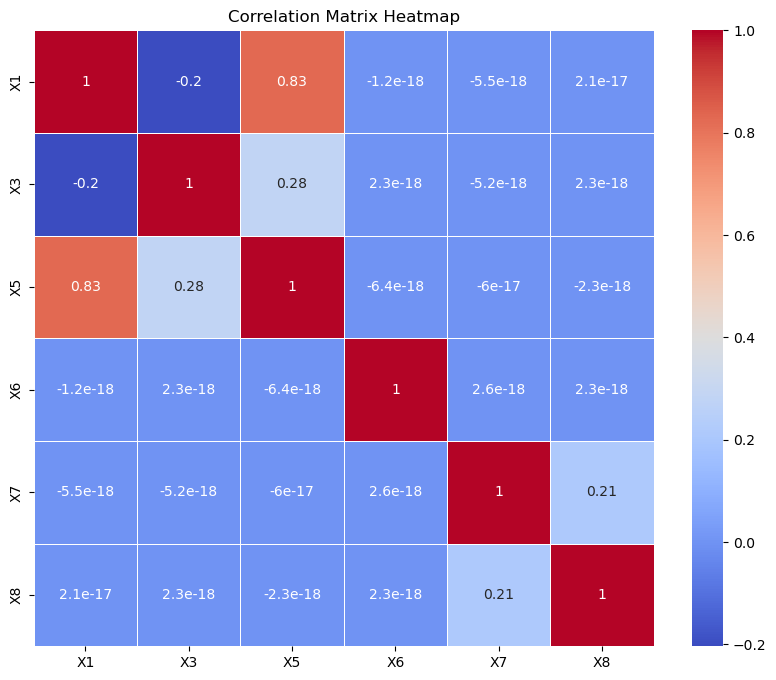

In [134]:
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Matrix Heatmap")
plt.show()

Split the dataset into 2 parts: training and validation set.

In [135]:
X_train, X_val, y_train, y_val = train_test_split(X.to_numpy(), y.to_numpy(), test_size=0.2, random_state=0)

Define a function ```eval_genomes``` to calculate the fitness of the genomes.

In [136]:
def eval_genome(genome, config, X, y):
    net = neat.nn.FeedForwardNetwork.create(genome, config)

    squared_errors = []
    for i in range(len(X)):
        input_data = X[i]
        target_output = y[i]
        output = net.activate(input_data)
        squared_error = np.mean((output - target_output) ** 2)
        squared_errors.append(squared_error)

    mse = -np.mean(squared_errors)
    return mse

def eval_genomes(genomes, config):
    for _, genome in genomes:
        mse = eval_genome(genome, config, X_train, y_train)
        genome.fitness = mse

Define a custom class ```MyReporter``` to save to a text file the fitness of the best individual, as well as its fitness calculated on the validation set, for each generation. You can leverage this class to save also some statistics of interest.

In [137]:
class MyReporter(neat.reporting.BaseReporter):
    def __init__(self, file_path):
        self.file_path = file_path
        self.generation = 0
        self.best_train_history = []
        self.best_val_history = []
        with open(self.file_path, 'w') as file:
            file.write(f"Generation,Train_fitness,Validation_fitness\n")

    def post_evaluate(self, config, population, species, best_genome):
        self.generation += 1

        best_train_fitness = best_genome.fitness
        self.best_train_history.append(best_train_fitness)

        best_val_fitness = eval_genome(best_genome, config, X_val, y_val)
        self.best_val_history.append(best_val_fitness)

        with open(self.file_path, 'a') as file:
            file.write(f"{self.generation},{best_train_fitness},{best_val_fitness}\n")

Configure the parameters into the ```neat_config.txt```. You can try several settings and see which is better for the task ([documentation](https://neat-python.readthedocs.io/en/latest/config_file.html)).

In [138]:
config = neat.Config(neat.genome.DefaultGenome,
                     neat.reproduction.DefaultReproduction,
                     neat.species.DefaultSpeciesSet,
                     neat.stagnation.DefaultStagnation,
                     "./neat_config.txt")

Define the initial population with the chosen configuration.

In [139]:
population = neat.Population(config)

history_path = "./history.txt"
population.add_reporter(MyReporter(history_path))

We can row run our NEAT algorithm for a given number of generation.

In [140]:
winner = population.run(eval_genomes, 100)

Visualize the results and plot the history of both training and validation fitness.

In [141]:
print(f'Best genome:\n{winner}')

Best genome:
Key: 4993
Fitness: -12.492824464791234
Nodes:
	0 DefaultNodeGene(key=0, bias=2.24759535110211, response=1.0, activation=relu, aggregation=sum)
	1 DefaultNodeGene(key=1, bias=0.9925006102540432, response=1.0, activation=identity, aggregation=sum)
	24 DefaultNodeGene(key=24, bias=7.962225441347185, response=1.0, activation=relu, aggregation=sum)
Connections:
	DefaultConnectionGene(key=(-6, 1), weight=-1.1433641790191318, enabled=True)
	DefaultConnectionGene(key=(-6, 24), weight=0.5468795366677431, enabled=True)
	DefaultConnectionGene(key=(-5, 0), weight=1.3930267334444033, enabled=True)
	DefaultConnectionGene(key=(-5, 1), weight=-1.5957595425197368, enabled=False)
	DefaultConnectionGene(key=(-5, 24), weight=0.49839088250905916, enabled=True)
	DefaultConnectionGene(key=(-4, 0), weight=-0.7371672592397616, enabled=True)
	DefaultConnectionGene(key=(-3, 0), weight=4.6387891920814575, enabled=False)
	DefaultConnectionGene(key=(-3, 1), weight=-1.081659517761065, enabled=True)
	Def

In [142]:
eval_genome(winner, config, X_val, y_val)

-13.912802361755876

In [143]:
history_df = pd.read_csv(history_path)

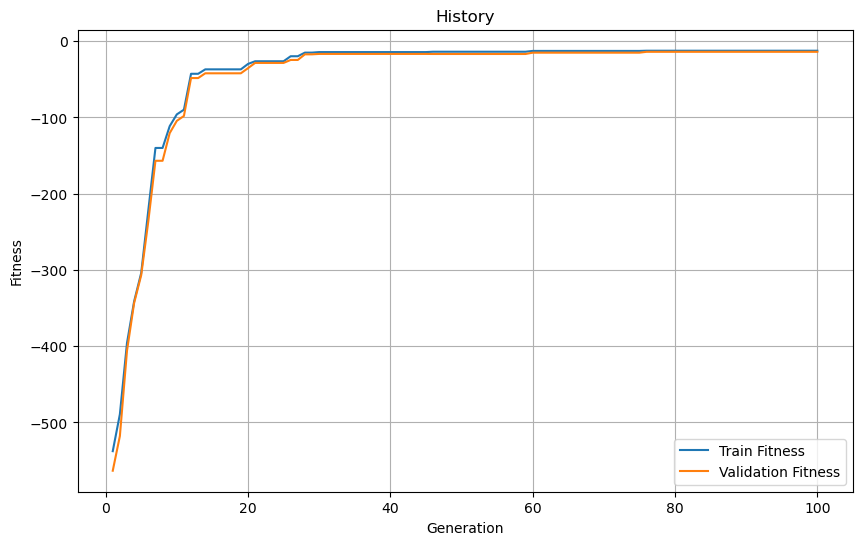

In [144]:
plt.figure(figsize=(10, 6))

plt.plot(history_df['Generation'], history_df['Train_fitness'], label='Train Fitness')
plt.plot(history_df['Generation'], history_df['Validation_fitness'], label='Validation Fitness')

plt.title('History')
plt.xlabel('Generation')
plt.ylabel('Fitness')
plt.legend()
plt.grid(True)

plt.show()

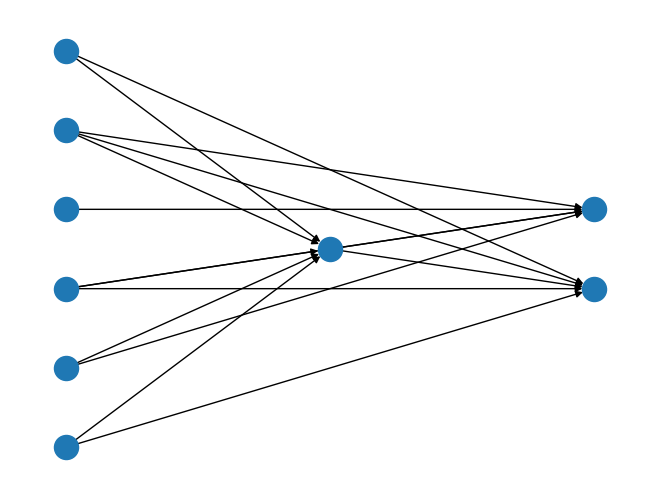

In [145]:
n_outputs = 2
n_inputs = 6
g = nx.DiGraph()
for name in range(-n_inputs, 0):
    g.add_node(name, node_type=0)
for name in winner.nodes.keys():
    if name < n_outputs:
        node_type = 2
    else:
        node_type = 1
    g.add_node(name, node_type=node_type)
for i,j in winner.connections.keys():
    g.add_edge(i, j)
pos = nx.multipartite_layout(g, subset_key="node_type")
nx.draw(g, pos=pos)